<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Features-Importance" data-toc-modified-id="Features-Importance-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Features Importance</a></span><ul class="toc-item"><li><span><a href="#Reading-and-preparing-the-dataset" data-toc-modified-id="Reading-and-preparing-the-dataset-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Reading and preparing the dataset</a></span><ul class="toc-item"><li><span><a href="#Set-target-variable-and-categorical-features" data-toc-modified-id="Set-target-variable-and-categorical-features-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Set target variable and categorical features</a></span></li><li><span><a href="#Binning-numerical-features" data-toc-modified-id="Binning-numerical-features-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Binning numerical features</a></span></li><li><span><a href="#Onehot-encode-the-features-to-have-numerical-values" data-toc-modified-id="Onehot-encode-the-features-to-have-numerical-values-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Onehot encode the features to have numerical values</a></span></li><li><span><a href="#Split-the-dataset" data-toc-modified-id="Split-the-dataset-1.1.4"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>Split the dataset</a></span></li></ul></li><li><span><a href="#Logistic-regression-(Filtering)" data-toc-modified-id="Logistic-regression-(Filtering)-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Logistic regression (Filtering)</a></span></li><li><span><a href="#RelieF-Algorithm" data-toc-modified-id="RelieF-Algorithm-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>RelieF Algorithm</a></span></li><li><span><a href="#Wrapper-methods..." data-toc-modified-id="Wrapper-methods...-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Wrapper methods...</a></span></li><li><span><a href="#Matching-between-the-three-methods?" data-toc-modified-id="Matching-between-the-three-methods?-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Matching between the three methods?</a></span></li></ul></li></ul></div>

# Features Importance 

This notebook shows how to extract features importance from fitting a **simple linear method**. In this case, we're using a logistic regression to plot what is the value of the differente coefficients.

In [3]:
from dataset import Dataset as dataset
from sklearn.linear_model import LogisticRegression
from typing import List
from skrebate import ReliefF

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


def plot_importance(features: List[str], importances: List[float]):

    num_features = len(features)
    indices = np.argsort(importances)

    plt.figure(figsize=(8, 10))
    plt.title("Feature importances")
    plt.barh(range(num_features), importances[indices],
             color="r",
             xerr=np.std(importances),
             align="center")
    plt.yticks(range(num_features), features[indices])
    plt.ylim([-1, num_features])
    plt.show()

## Reading and preparing the dataset

http://archive.ics.uci.edu/ml/datasets/Contraceptive+Method+Choice

    1. Wife's age                     (numerical)
    2. Wife's education               (categorical)      1=low, 2, 3, 4=high
    3. Husband's education            (categorical)      1=low, 2, 3, 4=high
    4. Number of children ever born   (numerical)
    5. Wife's religion                (binary)           0=Non-Islam, 1=Islam
    6. Wife's now working?            (binary)           0=Yes, 1=No
    7. Husband's occupation           (categorical)      1, 2, 3, 4
    8. Standard-of-living index       (categorical)      1=low, 2, 3, 4=high
    9. Media exposure                 (binary)           0=Good, 1=Not good
    10. Contraceptive method used     (class attribute)  1=No-use 
                                                         2=Long-term
                                                         3=Short-term

In [6]:
URL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/cmc/cmc.data'
df = dataset(URL, header=None)
df.to_int(df.names());

### Set target variable and categorical features

Reduce nr. of categories in target feature: from 3 to 2

Since we've 3 classes and we can only work with 2 (logit is binomial).

Merge categories Short/Long term (values 2.0 and 3.0) into a new one valued 0.0.

As a final step  with `x9`, set it as the target variable.

In [7]:
df.merge_values(column='x9', old_values=[2, 3], new_value=0)
df.to_int('x9').set_target('x9');

Make these columns categorical, as per description

In [8]:
df = df.to_categorical(['x1','x2','x4','x5','x6','x7','x8'])

### Binning numerical features

Age ranges between 16 and 49, so we'll discretize it into (say) 6 buckets. 

Number of sons ranges from 0 to 16, so we create (also) 6 buckets.

In [5]:
df.discretize('x0', [(15, 20), (20, 25), (25, 30), (30, 35), (35, 40), (40, 50)])
df.discretize('x3', [(0, 2), (2, 4), (4, 6), (6, 8), (8, 10), (10, 20)])

### Onehot encode the features to have numerical values

In [6]:
df.onehot_encode(df.names('features'));

### Split the dataset

In [7]:
X, y = df.split(test_size=0.2)

## Logistic regression (Filtering)

After fitting the logit, the coefficient values are stored in the `coef_` internal variable. 

- We pass them to a plotting function that will sort them out in decreasing order. 
- We pass the `abs()` of them, since we're interested in their influence in this model, and negative influence simply indicates that the higher this value, the higher the log of the odds towards the negative class (`0`).
- It may also be considered to plot:

$$
| std(X) \cdot \beta |
$$

instead of simply passing the coefficients ($\beta$), but results are lineaerly equivalent.

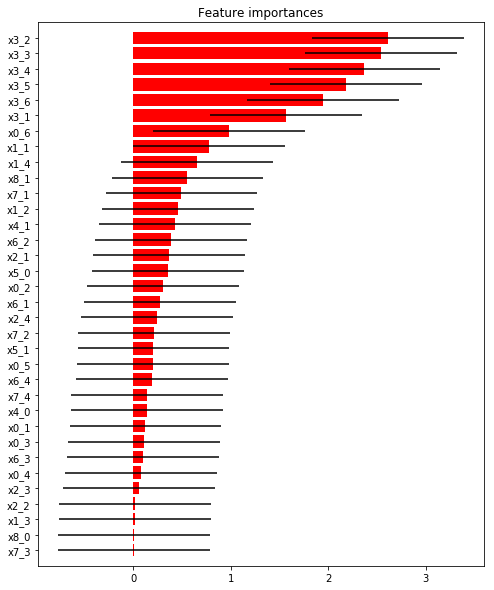

In [8]:
lr = LogisticRegression().fit(X.train, y.train)
plot_importance(df.features.columns, np.abs(lr.coef_[0]))

Let's print the names of the top 10 features selected by the Logistic Regression algorithm.

In [9]:
# Get the index number of the coefficients, sorted in descending order.
indices = np.argsort(-np.abs(lr.coef_[0]))

# Use the indices to retrieve the feature names
top_LR_feature_names = [X.train.columns[i] for i in indices]
print(top_LR_feature_names[:10])

['x3_2', 'x3_3', 'x3_4', 'x3_5', 'x3_6', 'x3_1', 'x0_6', 'x1_1', 'x1_4', 'x8_1']


## RelieF Algorithm

Let's use an implementation of RELIEF algorithm that we can find [here](https://github.com/EpistasisLab/scikit-rebate). We will simply specify how many neighbours to consider when comparing each feature with the rest, to measure differences, and how many features do we want at the end of the process.

The only caveat is the algorithm expects the values as Numpy arrays with shapes $(m, p)$ for the features ($m$ is the number of tuples/samples and $p$ is the number of predictors/features), and $(m, 1)$ for the target variable (a 1D numpy array, for which we must use the function `ravel()` from Numpy).

No. of tuples, No. of Columns before ReliefF : (1178, 34)
No. of tuples , No. of Columns after ReliefF : (1178, 10)


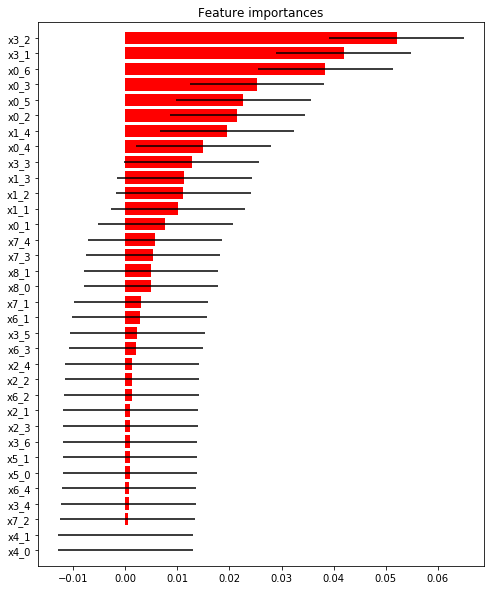

In [10]:
my_features = X.train.values        # the numpy array inside the dataframe
my_labels = y.train.values.ravel()  # the target variable as a 1D array.

fs = ReliefF(n_features_to_select=10, n_neighbors=34)
fs.fit(my_features, my_labels)
my_important_features = fs.transform(my_features)

print("No. of tuples, No. of Columns before ReliefF : "+str(my_features.shape)+
      "\nNo. of tuples , No. of Columns after ReliefF : "+str(my_important_features.shape))

# Plot the importances, taken from the `fs` variable.
plot_importance(X.train.columns, abs(fs.feature_importances_))

Let's print the names of the top 10 features selected by the RELIEF algorithm.

In [11]:
top_RELIEF_feature_names = [X.train.columns[i] for i in abs(fs.top_features_)]
print(top_RELIEF_feature_names[:10])

['x3_2', 'x3_1', 'x0_6', 'x0_3', 'x0_5', 'x0_2', 'x1_4', 'x0_4', 'x3_3', 'x1_3']


In [12]:
set_LR = set(top_LR_feature_names[:10])
set_RL = set(top_RELIEF_feature_names[:10])
print(set_LR)
print(set_RL)

{'x3_2', 'x3_5', 'x3_6', 'x8_1', 'x1_4', 'x3_4', 'x0_6', 'x3_1', 'x3_3', 'x1_1'}
{'x3_2', 'x1_4', 'x0_3', 'x3_3', 'x0_2', 'x0_6', 'x1_3', 'x3_1', 'x0_4', 'x0_5'}


## Wrapper methods...

Let's find the top features from a wrapper method implemented in dataset that uses forward and backward stepwise selection, and compare results.

Unfortunately, with this method we don't have information about feature importance.

In [40]:
df.target.astype(float)               # We need target to be float to run the stepwise method
top_SW_features = df.stepwise_selection()
print('Top stepwise selection features:\n -> ', top_SW_features)

Top stepwise selection features:
 ->  ['x3_2', 'x1_4', 'x0_6', 'x3_3', 'x1_3', 'x3_4', 'x3_1', 'x3_5', 'x3_6', 'x8_0', 'x0_5', 'x7_1']


## Matching between the three methods?

In [42]:
set_SW = set(top_SW_features)

# Compute the different interesections between the sets 
# obtained by the different methods
LR_RL_in_common = set_LR.intersection(set_RL)
SW_LR_in_common = set_SW.intersection(set_LR)
SW_RL_in_common = set_SW.intersection(set_RL)

print('Logistic matches', len(LR_RL_in_common),\
      'features with RELIEF:', set_LR.intersection(set_RL))
print('Stepwise matches', len(SW_LR_in_common),\
      'features with Logistic Regression:', SW_LR_in_common)
print('Stepwise matches', len(SW_RL_in_common),\
      'features with RELIEF:', SW_RL_in_common)

Logistic matches 5 features with RELIEF: {'x3_2', 'x3_1', 'x0_6', 'x1_4', 'x3_3'}
Stepwise matches 8 features with Logistic Regression: {'x3_2', 'x3_5', 'x3_6', 'x3_1', 'x3_4', 'x0_6', 'x1_4', 'x3_3'}
Stepwise matches 7 features with RELIEF: {'x3_2', 'x3_1', 'x0_6', 'x1_3', 'x1_4', 'x3_3', 'x0_5'}
